In [ ]:
!pip install alibi==0.9.5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_source = """The data comes from Aravind Eye Hospital, consisting of 3662 retina images taken using fundus photography
with patients demographic information(age, gender), names are compeletly hidden for privacy. A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4.
We can see that female consists 80% and male 20%, suggesting our model could potentially perform better on female patients' scans.
Age are from 20-80 distributed uniformly. And for the severity label, 0 is the most, then 2 consists large amount, and class 1,4,3 are fewer number.
"""

In [ ]:
# Generate explanations
explanations = """
SLIC Segmentation for Ophthalmologists:
<br>
Simple Linear Iterative Clustering (SLIC) segmentation is used in our diabetic retinopathy detection tool to enhance the precision
of identifying key retinal features. For ophthalmologists, who are the primary stakeholders of this technology, SLIC provides a
visual representation of superpixels, aiding in the detection of lesions and hemorrhages critical for diagnosis. The contribution of
each segment in a model's prediction is determined by measuring the impact of altering or removing that segment on the model's output,
often quantified using methods like feature importance scores or sensitivity analysis. It serves as a
bridge between raw AI output and clinical decision-making, offering a transparent view into the model's functioning, thereby
bolstering confidence in the AI's diagnostic support."""
# ...

In [ ]:
model_arc = """We use in our product ResNet50, which is a deep convolutional neural network architecture consisting of 50 layers and is widely used in
image recognition tasks. It is known for its high accuracy, robustness and efficiency, making it a popular choice for various computer
vision applications. The model is designed to handle complex image data efficiently and accurately, with a total of 27,794,309
parameters. This extensive number of parameters allows ResNet50 to learn detailed and intricate patterns in the data,
leading to high performance across many challenging datasets."""


In [ ]:
model_acc = """Our model, based on the ResNet50 architecture, has demonstrated strong performance in detecting diabetic retinopathy
 from smartphone-captured eye images. Throughout its training phase, the model achieved an impressive accuracy of 0.89,
 indicating a high level of reliability in identifying patterns indicative of the condition. When evaluated on a separate
 test dataset, the model maintained a robust accuracy of 0.84, confirming its effectiveness and generalizability in
 real-world scenarios. This performance underscores the model's potential as a valuable tool in medical diagnostics,
 particularly for accessible screening in diverse settings."""

In [ ]:
model_confusion = """

The confusion matrix displayed showcases the performance of our diabetic retinopathy detection model across five categories,
from '0-No DR' to '4-Proliferative DR.' The diagonal elements represent the proportions of true positive predictions for each class,
indicating that the model is highly accurate in identifying '0-No DR' with 98% accuracy. It also performs well for '1-Mild' and
'2-Moderate' cases with 72% and 88% predicted correctly respectively. However, there is room for improvement in '3-Severe' and '4-Proliferative
DR' categories, with accuracies of 36% and 52%, respectively, suggesting a lower accuracy in these advanced stages. For '3-Severe' and '4-Proliferate DR the model
tend to predict as '2-Moderate'y, underestimating the serverness, therefore it needs physician's attention in the '2-Moderate' prediction,
because other classes may be wrongly predicted as '2-Moderate'.
"""

In [ ]:
diagnosis_dict = {0: 'No DR',
                  1: 'Mild',
                  2: 'Moderate',
                  3: 'Severe',
                  4: 'Proliferative DR'}


In [ ]:
# generator for html template
def generate_html(html_name, id):
      # Load data
      train = pd.read_csv('/content/drive/MyDrive/Explainability Exercise/data/train.csv')
      test = pd.read_csv('/content/drive/MyDrive/Explainability Exercise/data/test.csv')
      # Preprocecss data
      train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
      test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
      df = pd.concat([train, test], axis=0)


      row = df[df['id_code']==id+".png"]
      print(row)
      sex = row['gender'].values[0]
      age = row['age'].values[0]

      html = open("explanation_template.html").read()
      html = html.replace("PXX", "Confidential")
      html = html.replace("IXX", id)

      html = html.replace("GXX", sex)
      html = html.replace("AGG", str(age))
      html = html.replace("datainfo", data_source)
      html = html.replace("modelarc", model_arc)
      html = html.replace("modelacc", model_acc)
      html = html.replace("modelconfusion", model_confusion)

#-----------------------------------------------------------------------------------------------
      from PIL import Image
      import os
      from tensorflow.keras.preprocessing import image as tfimage
      import numpy as np
      base_train_path = "/content/drive/MyDrive/Explainability Exercise/data/train_images"
      base_test_path = "/content/drive/MyDrive/Explainability Exercise/data/test_images"
      image_filename = id+".png"
      train_img_path = os.path.join(base_train_path, image_filename)
      test_img_path = os.path.join(base_test_path, image_filename)

      if os.path.exists(train_img_path):
          img_path = train_img_path
      elif os.path.exists(test_img_path):
          img_path = test_img_path
      else:
          raise FileNotFoundError(f"Image {image_filename} not found in train or test directories.")

      image = Image.open(img_path).resize((320, 320))
      image = tfimage.img_to_array(image)  # Convert the image to a numpy array
      image /= 255.0

      plt.imshow(image)

      model = tf.keras.models.load_model("/content/drive/MyDrive/Explainability Exercise/model.h5")

      pred_probability = model.predict(tf.expand_dims(image, axis=0)).round(2)[0]
      class_probability = {v : pred_probability[k] for k,v in diagnosis_dict.items()}
      prediction = pred_probability.argmax(axis = -1)

      plt.title("Prediction: "+ str(prediction) + "-"+ diagnosis_dict[prediction] +  ", Class Probability: "+ str(class_probability), loc='center', wrap=True)
      plt.savefig('IMAGE_FOR_DISPLAY.png')
      plt.show()

#-----------------------------------------------------------------------------------------------
      # print(image.shape)
      from alibi.explainers import AnchorImage
      predict_fn = lambda x: model.predict(x).argmax(-1)
      image_shape = image.shape
      segmentation_fn = 'slic' # choose from different segmentation functions - https://scikit-image.org/docs/dev/api/skimage.segmentation.html
      kwargs = {'n_segments': 3, 'compactness': 20, 'sigma': .5, 'start_label': 0} # play around with parameters
      explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                              segmentation_kwargs=kwargs, images_background=None)
      explanation = explainer.explain(image, threshold=.95, delta=0.3, p_sample=.5, tau=0.25) # play around with parameters
      plt.imshow(explanation.anchor)
      plt.title("Prediction: "+ str(prediction) + "-"+ diagnosis_dict[prediction] +  ", Class Probability: "+ str(class_probability), loc='center', wrap=True)
      plt.savefig('IMAGE_EXPLAIN.png')
      plt.show()

#-----------------------------------------------------------------------------------------------
      html = html.replace("DXX", diagnosis_dict[prediction])
      html = html.replace("EXPLANATION", explanations)

      with open(html_name, "w") as fp:
          fp.write(html)

               id_code  age gender  diagnosis
2458  000c1434d8d7.png   64      F          2
1/1 [==============================] - 1s 960ms/step


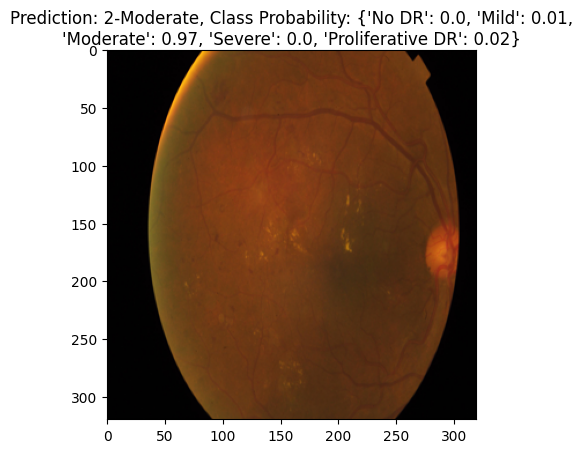

4/4 [==============================] - 3s 756ms/step


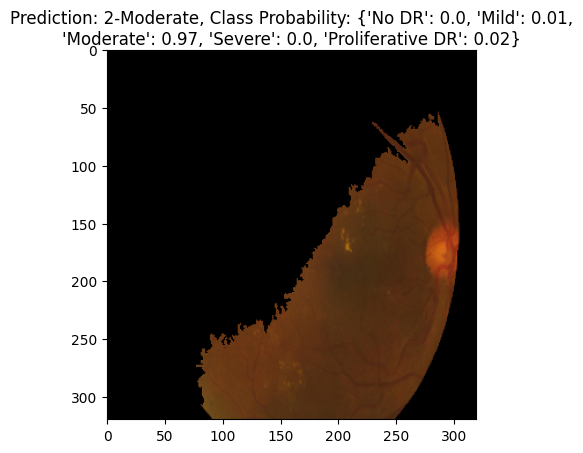

In [ ]:
# Populate the html template
# generate_html("test.html", "00a8624548a9")
generate_html("test1.html", "000c1434d8d7")

               id_code  age gender  diagnosis
2801  05339950962e.png   43      F          0
1/1 [==============================] - 1s 982ms/step


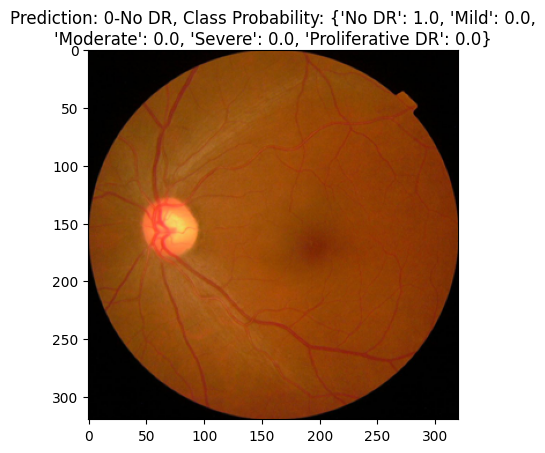

4/4 [==============================] - 3s 760ms/step


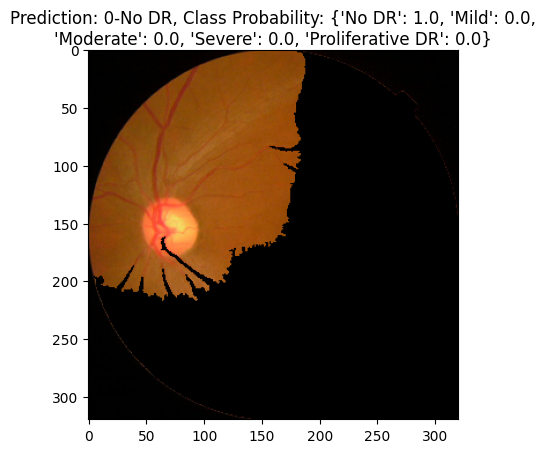

In [ ]:
generate_html("test2.html", "05339950962e")